In [1]:
!pip install spacy

In [2]:
! nvidia-smi

Sat Jan 15 23:23:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Modules for languages
# en_core_web_sm - for English
# it_core_news_sm - for Italian
# es_core_news_sm - for Spanish

!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
import re
import gensim
import glob
import en_core_web_sm
import pandas as pd
import os
import numpy as np

In [6]:
!pip install contractions

     |████████████████████████████████| 284 kB 4.3 MB/s 
     |████████████████████████████████| 321 kB 49.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=8c750345e363a824b01bf505d41110ca34773f158ebc27d51582a41472e46d06
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [7]:
!pip install unidecode

     |████████████████████████████████| 235 kB 4.1 MB/s 


In [8]:
from datetime import datetime
import codecs
from bs4 import BeautifulSoup
import unidecode
import contractions

In [9]:
def decontracted(phrase):

    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)
    
    #remove html tags from text
    soup = BeautifulSoup(phrase, "html.parser")
    phrase = soup.get_text(separator=" ")
    
    #remove accented characters from text, e.g. café
    phrase = unidecode.unidecode(phrase)
    
    sentences = re.split('([.;!?] *)', phrase)

    return ' '.join([i.capitalize() for i in  sentences])

In [10]:
def prepare_english_text(input_path, output_path, error_list,
                         max_len = 5000000, enc = 'utf-8', gutenberg = True, title = ''):
    
    #English pipeline optimized for CPU. 
    #Components: tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer.
    
    #parser: The dependency parser jointly learns sentence segmentation and labelled dependency parsing, 
    #and can optionally learn to merge tokens that had been over-segmented by the tokenizer.
    
    nlp = en_core_web_sm.load(disable=['parser'])
    nlp.max_length = max_len
    
    pos_dict = {'PROPN': 'PERSON1', 'PRON': 'PRON1', 'NUM': 'ORDINAL1'}

    
    try:
        raw_text = codecs.open(input_path, 'r', enc).read()
    except:
        return -1
    
    if gutenberg:
        begin = raw_text.find('*** START OF THIS PROJECT GUTENBERG EBOOK ')
        begin_2 = begin + 42 + len(title) + 3
        if begin == -1:
                begin = raw_text.find('START OF THE PROJECT GUTENBERG EBOOK ')
                begin_2 = begin + 37 + len(title) + 3

        end = raw_text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
        if end == -1:
            end = raw_text.find('*** END')
        raw_text = raw_text[begin_2 : end]
        
    
    preprocessed_text = decontracted(raw_text)
    
    nlp_doc = nlp(preprocessed_text)
    sorted_ents = sorted(nlp_doc.ents, key = lambda x: len(x), reverse =  True)


    for ent in sorted_ents:
        preprocessed_text = preprocessed_text.replace(' ' + ent.text + ' ', ' ' + ent.label_+ '1 ')
        
        if not ent.text.islower():
            preprocessed_text = preprocessed_text.replace(' ' + ent.text.lower() + ' ', ' ' + ent.label_+ '1 ')

    new_nlp_doc = nlp(preprocessed_text)
    file_name = path.split('/')[-1]
    

    with open(output_path + file_name, 'w+', ) as prepared_text:
        for token in new_nlp_doc:
            if token.text[-1] != '1':
                if token.pos_ in pos_dict:
                    try:
                        prepared_text.write(pos_dict[token.pos_])
                    except:
                        error_list.append(token.pos_)
                    prepared_text.write('\n')
                    
                        
                    
                elif token.pos_ != 'PUNCT':
                    try:
                        prepared_text.write(token.lemma_.lower())
                    except:
                        error_list.append(token.pos_)
                        
                    prepared_text.write('\n')
                    

            else:
                try:
                    repared_text.write(token.text)
                except:
                        error_list.append(token.pos_)
                prepared_text.write('\n')
    return 1

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataframe

dir_books_en = list(glob.glob("/content/drive/MyDrive/2022-01-15_Course_project/books_en/*.txt"))

In [ ]:
len(dir_books_en)

8214

In [ ]:
# Example
dir_books_en[0]

'/content/drive/MyDrive/2022-01-15_Course_project/books_en/17784-8.txt'

In [ ]:
dict_book_en = dict()
num = 0

for book in dir_books_en:
    try:
        with open(book) as f:
            lines = f.read()
    
    except:
        try:
            with open(book, encoding="utf8") as f:
                lines = f.read()
        except:
            try:
                lines = codecs.open(book, 'r', 'ISO-8859-1').read()

        
            except:
                dict_s['length'] = -1
                dict_s['ebook_num'] = book.split("\\")[1].split('.')[0]
                dict_s['ebook_dir'] = book

                dict_s['Title'] = ''
                dict_s['Language'] = ''
                dict_s['encoding'] = ''
                dict_book_en[num] = dict_s
                continue
            
        
        
    info_beg = lines.find('Title: ')
    begin = lines.find('*** START OF THIS PROJECT GUTENBERG EBOOK')
    if begin == -1:
            begin = lines.find('START OF THE PROJECT GUTENBERG EBOOK')
            
    end = lines.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
    if end == -1:
        end = lines.find('*** END')
        
    info = lines[info_beg : begin].split('\n')
    dict_s = dict()
    
    for i in info:
            
        if i.find('Title: ') > -1:
            dict_s['Title'] = i.split('Title: ')[1]
            
        if i.find('Language: ') > -1:
            dict_s['Language'] = i.split('Language: ')[1]
            
        if i.find('Character set encoding: ') > -1:
            dict_s['encoding'] = i.split('Character set encoding: ')[1]
            
    with open(book, 'w', encoding='utf8') as fn:
        fn.write(lines)
             
    dict_s['length'] = len(lines[begin : end].split(' '))
    dict_s['ebook_num'] = book.split("/")[-1].split('.txt')[0]
    dict_s['ebook_dir'] = book
    dict_book_en[num] = dict_s
    num += 1

In [ ]:
file_list = pd.DataFrame(dict_book_en.values())
file_list.head()

,Title,Language,encoding,length,ebook_num,ebook_dir
0,The Story of Bawn,English,ISO-8859-1,58501,17784-8,/content/drive/MyDrive/2022-01-15_Course_proje...
1,Divers Women,English,ISO-8859-1,50277,17785-8,/content/drive/MyDrive/2022-01-15_Course_proje...
2,Molly McDonald,English,ISO-8859-1,74599,17789-8,/content/drive/MyDrive/2022-01-15_Course_proje...
3,Jane Field,English,ASCII,44093,17790,/content/drive/MyDrive/2022-01-15_Course_proje...
4,The Jamesons,English,ASCII,26429,17792,/content/drive/MyDrive/2022-01-15_Course_proje...


In [12]:
# /content/drive/MyDrive/2022-01-15_Course_project/books_en/
if not os.path.exists('/content/drive/MyDrive/2022-01-15_Course_project/prep_en/'):
    try:
        os.makedirs('/content/drive/MyDrive/2022-01-15_Course_project/prep_en/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [ ]:
print('max length of book: ', max(file_list['length']))

max length of book:  5517395


In [13]:
def make_pieces(file_in, file_out, min_lenght = 1000, gutenberg = True, max_count = None):
    file_list = glob.glob(file_in + '*')
    print('number of files: ', len(file_list))
    list_full = []
    list_error = []
    num_ = 0
    count_ = 0
    
    for file_path in file_list:
        try:
            with open(file_path, 'r') as f:
                text = f.read()
    
        except:
            try:
                with open(file_path, 'r', encoding="utf8") as f:
                    text = f.read()
            except:
                try:
                    text = codecs.open(file_path, 'r', 'ISO-8859-1').read()
                except:
                    list_error.append(file_path)
        
            
        if gutenberg:
            info_beg = text.find('Title: ')
            begin = text.find('*** START OF THIS PROJECT GUTENBERG EBOOK ')
            title = ''
            
            if begin > -1:
                for i in text[info_beg : begin].split('\n'):
                    if i.find('Title: ') > -1:
                        title = i.split('Title: ')[1]
                begin_2 = begin + 42 + len(title) + 3
                
            else:
                begin = text.find('START OF THE PROJECT GUTENBERG EBOOK ')
                for i in text[info_beg : begin].split('\n'):
                    if i.find('Title: ') > -1:
                        title = i.split('Title: ')[1]
                begin_2 = begin + 37 + len(title) + 3

            end = text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
            if end == -1:
                end = text.find('*** END')
            text = text[begin_2 : end]
            
        text_split = text.split('\n')
        len_text =  len(text_split)
        piece_num = len_text // min_lenght
            
        file_name = file_path.split('/')[-1].split('.txt')[0]
        
        if num_ % 500 ==0:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            print(dt_string, '| ',  'number of processed files: ' + str(num_), round(num_/len(file_list), 3))
            
        
        if piece_num > 1:
            for i in range(piece_num -1):
                text_cut = ' '.join([s for s in text_split[i*min_lenght : (i+1)*min_lenght]])
                with open(file_out + file_name + '_piece'+str(i)+'.txt', 'w+') as output_file:
                    try:
                        output_file.write(text_cut)
                    except:
                        list_error.append(file_out + file_name + '_piece'+str(i)+'.txt')
        
        text_cut = ' '.join([s for s in text_split[max(piece_num - 1, 0) * min_lenght : ]])
        with open(file_out + file_name + '_piece'+str(piece_num)+'.txt', 'w+') as output_file:
            try:
                output_file.write(text_cut)
            except:
                list_error.append(file_out + file_name + '_piece'+str(piece_num)+'.txt')
            
        if piece_num ==0:
            list_full.append(file_out + file_name + '_piece'+str(piece_num)+'.txt')
        num_ += 1
        count_ += piece_num
        if max_count is not None:
            if max_count < count_:
                print('create max pieces!', count_, '| last file:', file_path)
                break
    return list_full, list_error

In [ ]:
file_list.sort_values('length', ascending = False)[:20]

,Title,Language,encoding,length,ebook_num,ebook_dir
6178,U.S. Copyright Renewals 1950 - 1977,English,ISO-8859-1,5517395,11800-8,/content/drive/MyDrive/2022-01-15_Course_proje...
5980,The Entire Project Gutenberg Works of Mark Twain,English,ASCII,2791905,3200,/content/drive/MyDrive/2022-01-15_Course_proje...
4765,The Complete Project Gutenberg Works of George...,English,ASCII,2487955,4500,/content/drive/MyDrive/2022-01-15_Course_proje...
3206,The Complete Historical Romances of Georg Ebers,English,ASCII,2367741,5600,/content/drive/MyDrive/2022-01-15_Course_proje...
4178,The Complete Project Gutenberg Works of Galswo...,English,ASCII,1598225,3254,/content/drive/MyDrive/2022-01-15_Course_proje...
4419,The Complete PG Edition of The Works of Winsto...,English,ASCII,1529821,5400,/content/drive/MyDrive/2022-01-15_Course_proje...
3186,"Project Gutenberg History of The Netherlands, ...",English,ASCII,1495809,4900,/content/drive/MyDrive/2022-01-15_Course_proje...
4678,"The Project Gutenberg Edition of ""The French I...",English,ASCII,1332145,4000,/content/drive/MyDrive/2022-01-15_Course_proje...
4658,The Project Gutenberg Historic Court Memoirs,English,ASCII,1265623,3900,/content/drive/MyDrive/2022-01-15_Course_proje...
4753,"Diary of Samuel Pepys, Complete",English,ASCII,1230195,4200,/content/drive/MyDrive/2022-01-15_Course_proje...


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = file_list.sort_values('length', ascending = False)['length'].to_list()

In [ ]:
perc_ = np.percentile(x, 99)

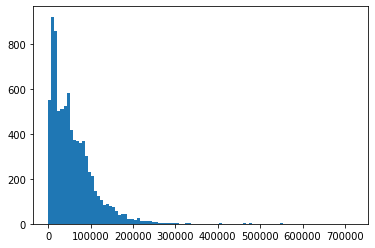

In [ ]:
plt.hist(x[20:], 100)
plt.show()

In [ ]:
sum_len = 0
ind = []
for i in file_list.sort_values('length', ascending = False).index:
    if  file_list.loc[i, 'length'] < perc_:
        sum_len += file_list.loc[i, 'length']
        ind.append(i)
    if sum_len > 20000000:
        break      

In [ ]:
len(ind)

89

In [ ]:
ind_all = [i for i in file_list.sort_values('length', ascending = False).index]

In [ ]:
# Let's process only big files, 
# because there are a lot of small files, which is why processing takes a very long time

tocken_error = []
prepare_book = []

num = 0
book_err = []
sum_len = 0


for i in ind_all:
    if num % 100 == 0:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print(dt_string, '| ',  'number of processed files: ' + str(num), '| count words:', sum_len)
    path = file_list.loc[i, 'ebook_dir']
    
    if file_list.loc[i, 'length'] < perc_ and file_list.loc[i, 'length'] > 1000:
        res = prepare_english_text(path, '/content/drive/MyDrive/2022-01-15_Course_project/prep_en/', tocken_error,  max_len = 5000000, 
                                   gutenberg = True, title = file_list.loc[i, 'Title'], enc = file_list.loc[i, 'encoding'])
        if res < 0:
            book_err.append(path)
            print('ERROR: ', path)
        else:
            
            prepare_book.append(path)
            sum_len += file_list.loc[i, 'length']
    num += 1
    if sum_len > 20000000:
        break

15/01/2022 16:44:42 |  number of processed files: 0 | count words: 0
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_en/10705.txt
15/01/2022 17:07:13 |  number of processed files: 100 | count words: 3924737
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_en/13124.txt
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_en/14587.txt
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_en/13529.txt
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_en/10681-body.txt
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_en/15171.txt


In [15]:
list_not_full , list_error = make_pieces('/content/drive/MyDrive/2022-01-15_Course_project/prep_en/', 
                                         '/content/drive/MyDrive/2022-01-15_Course_project/cut_en/', 
                                         min_lenght = 1500, gutenberg = False, max_count = 15000)

number of files:  90
15/01/2022 23:26:22 |  number of processed files: 0 0.0


In [16]:
len(glob.glob('/content/drive/MyDrive/2022-01-15_Course_project/cut_en/*'))

14788

# TF-IDF  and dictionary

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
def make_corpus(input_path, output_file_path):
    i = 0
    file_list = glob.glob(input_path + '*')
    
    with open(output_file_path, 'w+') as output_file:
        for file in file_list:
            if i % 100 == 0:
                now = datetime.now()
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                print(dt_string, '| ',  'number of processed files: ' + str(i), '| ', 
                      'percentage of completion:', str(round(i/len(file_list), 2)* 100) + ' %' )
            i+=1
            with open(file, 'r') as input_file:
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [22]:
make_corpus('/content/drive/MyDrive/2022-01-15_Course_project/cut_en/', 
            '/content/drive/MyDrive/2022-01-15_Course_project/english_corpus.txt') 

15/01/2022 23:35:04 |  number of processed files: 0 |  percentage of completion: 0.0 %
15/01/2022 23:35:04 |  number of processed files: 100 |  percentage of completion: 1.0 %
15/01/2022 23:35:13 |  number of processed files: 200 |  percentage of completion: 1.0 %
15/01/2022 23:35:13 |  number of processed files: 300 |  percentage of completion: 2.0 %
15/01/2022 23:35:13 |  number of processed files: 400 |  percentage of completion: 3.0 %
15/01/2022 23:35:14 |  number of processed files: 500 |  percentage of completion: 3.0 %
15/01/2022 23:35:14 |  number of processed files: 600 |  percentage of completion: 4.0 %
15/01/2022 23:35:14 |  number of processed files: 700 |  percentage of completion: 5.0 %
15/01/2022 23:35:14 |  number of processed files: 800 |  percentage of completion: 5.0 %
15/01/2022 23:35:14 |  number of processed files: 900 |  percentage of completion: 6.0 %
15/01/2022 23:35:14 |  number of processed files: 1000 |  percentage of completion: 7.000000000000001 %
15/01/20

In [23]:
def make_table_and_dict(corpus_path, min_df, max_df, token_pattern = None, use_idf = True, stop_words = 'english'):
    
    with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df)
        data_vectorized = vectorizer.fit_transform(corpus_file)
    return data_vectorized, vectorizer.get_feature_names(), vectorizer.idf_

In [24]:
en_data_vectorized, en_dictionary, en_idfs = make_table_and_dict('/content/drive/MyDrive/2022-01-15_Course_project/english_corpus.txt', 
                                                                 0.01,  0.8,
                                                                 token_pattern = '[A-Za-z]+',
                                                                 stop_words = stopwords.words('english'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
len(en_dictionary)

5057

In [26]:
en_data_vectorized.shape

(14788, 5057)

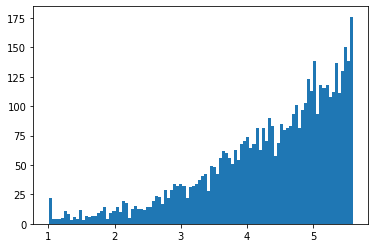

In [27]:
plt.hist(en_idfs, bins = 100)
plt.show()

In [28]:
max(en_idfs)

5.59769263422131

In [29]:
pairs = list(zip(en_dictionary, en_idfs))
sorted(pairs, key = lambda x: x[1])

[('a', 1.0017596106326812),
 ('of', 1.0018950936297724),
 ('and', 1.002098352548457),
 ('in', 1.0021661147033196),
 ('the', 1.0021661147033196),
 ('pron', 1.0023694287225215),
 ('to', 1.0026405783988033),
 ('person', 1.0031152673169492),
 ('with', 1.0041332172538553),
 ('for', 1.0056280874106014),
 ('by', 1.0076020185555703),
 ('on', 1.008010905027125),
 ('be', 1.0084199587552176),
 ('as', 1.0089656241394684),
 ('from', 1.01395862380827),
 ('at', 1.0155369394558647),
 ('have', 1.015742990488566),
 ('that', 1.0180123584466572),
 ('not', 1.0201488904975422),
 ('but', 1.0288801496247884),
 ('this', 1.0310400529205013),
 ('all', 1.0434625729190583),
 ('or', 1.0539695558493916),
 ('so', 1.0669712115420613),
 ('an', 1.084181583100198),
 ('no', 1.0872757361507532),
 ('make', 1.0978083954558289),
 ('when', 1.1014688036813465),
 ('do', 1.1026669467032173),
 ('other', 1.1324790404239067),
 ('if', 1.1645614813662464),
 ('into', 1.1649601259798574),
 ('more', 1.1687952217637998),
 ('take', 1.16999